In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
import numpy as np
from sklearn.metrics import classification_report

In [155]:
# Fijar semilla para reproducibilidad
seed_everything(123)

Seed set to 123


123

In [156]:
# Modelo MLP simple
class LitMLP(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 128)
        self.layer2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.layer1(x))
        return self.layer2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [157]:
def evaluate_model_with_classification_report(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for x, y in dataloader:
            logits = model(x.to(device))
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    print(classification_report(all_labels, all_preds))


In [158]:
# Cargar MNIST y dividir en train/val/test
transform = transforms.Compose([transforms.ToTensor()])
mnist_full = MNIST(root=".", train=True, download=True, transform=transform)
test_data = MNIST(root=".", train=False, download=True, transform=transform)

# División 80% train, 20% val
train_size = int(0.8 * len(mnist_full))
val_size = len(mnist_full) - train_size
train_data, val_data = random_split(mnist_full, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [159]:
# Entrenar modelo
model = LitMLP()
trainer = pl.Trainer(max_epochs=3, logger=False, enable_checkpointing=False)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 100 K  | train
1 | layer2 | Linear | 1.3 K  | train
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [160]:
# Evaluar en test
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9661999940872192     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9661999940872192}]

In [161]:
evaluate_model_with_classification_report(model, test_loader)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.94      0.96       982
           5       0.97      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [162]:
trainer.save_checkpoint("models/mlp_mnist.ckpt")

In [163]:
# Extraer y descomponer pesos de la primera capa
W = model.layer2.weight.detach().cpu().numpy()
U, S, Vt = np.linalg.svd(W, full_matrices=False)

print("Shapes:")
print("U:", U.shape)
print("S:", S.shape)
print("Vt:", Vt.shape)

Shapes:
U: (10, 10)
S: (10,)
Vt: (10, 128)


In [164]:
print("singular values:", S)

singular values: [2.4001405 2.2348666 2.1680954 2.0036085 1.8612914 1.7699178 1.5536627
 1.4437962 1.2288778 0.9897494]


In [165]:
S_MOD = S.copy()
S_MOD[8] *= 10
W_MOD = U @ np.diag(S_MOD) @ Vt
print("Modified singular values:", S_MOD)

Modified singular values: [ 2.4001405  2.2348666  2.1680954  2.0036085  1.8612914  1.7699178
  1.5536627  1.4437962 12.288778   0.9897494]


In [166]:
model_mod = LitMLP.load_from_checkpoint("models/mlp_mnist.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mod.layer2.weight = nn.Parameter(torch.tensor(W_MOD, dtype=torch.float32))
model_mod.to(device)

LitMLP(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)

In [167]:
evaluate_model_with_classification_report(model_mod, test_loader)

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       980
           1       0.99      0.54      0.70      1135
           2       0.84      0.91      0.87      1032
           3       0.96      0.84      0.89      1010
           4       0.94      0.02      0.03       982
           5       0.98      0.69      0.81       892
           6       0.68      0.99      0.80       958
           7       0.96      0.16      0.27      1028
           8       0.96      0.68      0.79       974
           9       0.28      0.99      0.44      1009

    accuracy                           0.67     10000
   macro avg       0.85      0.67      0.65     10000
weighted avg       0.85      0.67      0.65     10000



In [168]:
import matplotlib.pyplot as plt

def predict_single_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0)  # Añadir dimensión batch
        logits = model(image_tensor)
        pred = logits.argmax(dim=1).item()
    return str(pred)


In [170]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_hidden_states(model_to_view, dataloader, max_samples=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_to_view = model_to_view.to(device)
    model_to_view.eval()

    features = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            x_flat = x.view(x.size(0), -1)
            x_layer1 = F.relu(model_to_view.layer1(x_flat))
            hidden = model_to_view.layer2(x_layer1)
            features.append(hidden.cpu())
            labels.append(y)

            if len(features) * x.size(0) >= max_samples:
                break

    features = torch.cat(features)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    return features.numpy(), labels.numpy()

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE de los hidden states")
    plt.show()

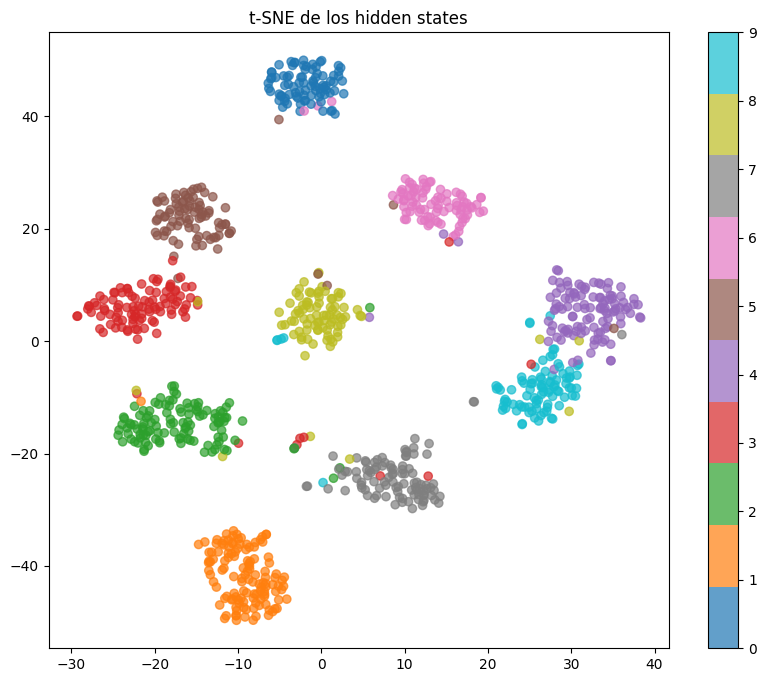

In [171]:
features, labels = extract_hidden_states(model, test_loader, max_samples=1000)
plot_tsne(features, labels)

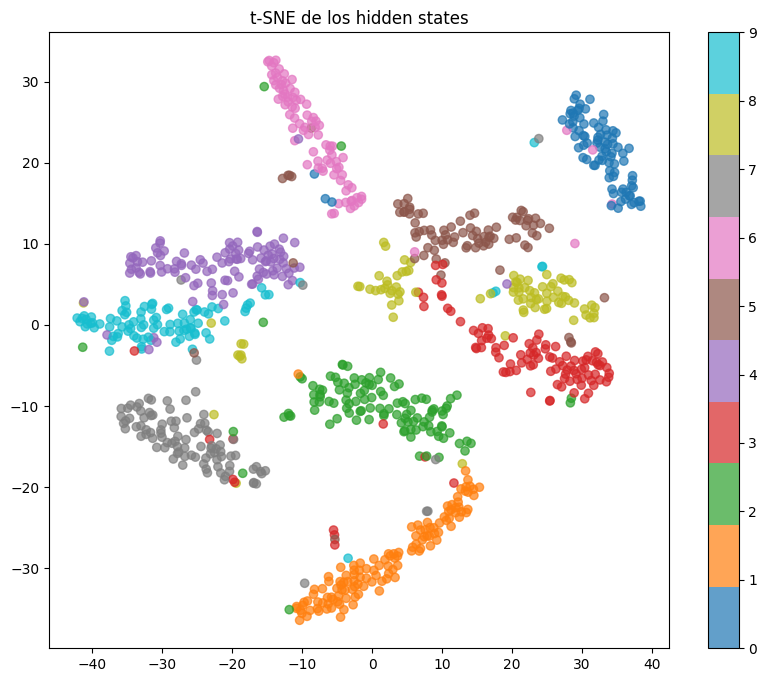

In [172]:
features, labels = extract_hidden_states(model_mod, test_loader, max_samples=1000)
plot_tsne(features, labels)

## Subsamples

In [173]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import transforms

# Función para filtrar clases permitidas
def filter_mnist_classes(dataset, allowed_classes):
    indices = [i for i, (_, label) in enumerate(dataset) if label in allowed_classes]
    return Subset(dataset, indices)

# Clases permitidas (0 a 6)
allowed_classes = set(range(7))

# Transformación
transform = transforms.Compose([transforms.ToTensor()])

# Cargar y filtrar datasets
mnist_train_full = MNIST(root=".", train=True, download=True, transform=transform)
mnist_test_full = MNIST(root=".", train=False, download=True, transform=transform)

filtered_train = filter_mnist_classes(mnist_train_full, allowed_classes)
filtered_test = filter_mnist_classes(mnist_test_full, allowed_classes)

# Dividir train en train/val (80/20)
train_size = int(0.8 * len(filtered_train))
val_size = len(filtered_train) - train_size
train_data, val_data = random_split(filtered_train, [train_size, val_size])

# DataLoaders
train_loader_fil = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader_fil = DataLoader(val_data, batch_size=64)
test_loader_fil = DataLoader(filtered_test, batch_size=64)

In [174]:
# train model with filtered data
model_filtered = LitMLP()
trainer_filtered = pl.Trainer(max_epochs=3, logger=False, enable_checkpointing=False)
trainer_filtered.fit(model_filtered, train_loader_fil, val_loader_fil)

/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/miguel/miniconda3/envs/vqa/lib/python3.11/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 100 K  | train
1 | layer2 | Linear | 1.3 K  | train
------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [175]:
# testear el modelo modificado
trainer_filtered.test(model_filtered, test_loader_fil)

/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/miguel/miniconda3/envs/vqa/lib/python3.11/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9771068692207336     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9771068692207336}]

In [178]:
evaluate_model_with_classification_report(model_filtered, test_loader_fil)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.94      0.98      0.96       892
           6       0.96      0.98      0.97       958

    accuracy                           0.98      6989
   macro avg       0.98      0.98      0.98      6989
weighted avg       0.98      0.98      0.98      6989



In [ ]:
evaluate_model_with_classification_report(model_filtered, test_loader)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       980
           1       0.88      0.99      0.93      1135
           2       0.85      0.96      0.90      1032
           3       0.50      0.96      0.66      1010
           4       0.51      0.98      0.67       982
           5       0.54      0.98      0.70       892
           6       0.91      0.98      0.94       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.68     10000
   macro avg       0.51      0.68      0.57     10000
weighted avg       0.51      0.68      0.58     10000



/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [179]:
# Guardar el modelo modificado
trainer_filtered.save_checkpoint("models/mlp_mnist_filtered.ckpt")

In [ ]:
S_ALL = S.copy()

In [ ]:
model_mod = LitMLP.load_from_checkpoint("models/mlp_mnist_filtered.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mod.layer2.weight = nn.Parameter(torch.tensor(W_MOD, dtype=torch.float32))
model_mod.to(device)